In [23]:
# Testing a whispering Gallery Mode

import meep as mp
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [24]:
# Characteristic lengthscale
a = 1  # micrometers

resolution = 20  # pixels/um
dimensions = mp.CYLINDRICAL

# Creating perfectly matched layers
dpml = 1.0
pml_layers = [mp.PML(dpml)]

# Source Wavelength
#wvln = 1.530  # micrometers
wvln = 1.51837  # micrometers for ErO G1

freq = 1 / wvln
df = 0.002

n = 1.44 # CaF2
alpha = 1e-10  # attenuation coeff in cm^-1
alpha_mu = alpha * 1e-4 # cm^-1 to micron^-1
k = wvln*alpha_mu/(4*np.pi)

complex_n = n + 1j*k
perm = complex_n**2
realPerm = np.real(perm)
imPerm = np.imag(perm)
#imPerm = 0
#realPerm = 12
cond = 2 * np.pi * freq * imPerm / realPerm

# Refractive index and ratio with index outside resonator
#n = np.sqrt(realPerm)
q = n / 1

# radial mode number
nrad = 1  # Set to 1 to get fundamental whispering gallery modes

# Which zero of the airy function we need
azs = special.ai_zeros(nrad)[0]
az = azs[nrad - 1]

In [25]:
def m2r(x):
    return 1 / (2 * np.pi * freq) * (x + 1 / 2 + az * ((x + 1 / 2) / 2) ** (1 / 3) - q / np.sqrt(q ** 2 - 1)
                                     + 3 * az / (2 ** (2 / 3) * 10 * (x + 1 / 2) ** (1 / 3)) + q ** 3 * az
                                     / (3 * 2 ** (1 / 3) * (q ** 2 - 1) ** (3 / 2) * (x + 1 / 2) ** (2 / 3)))


def m2rvar(x):
    return 1 / (2 * np.pi * freq) * (x + az * (x / 2) ** (1 / 3) - q / np.sqrt(q ** 2 - 1)
                                     + 3 * az / (2 ** (2 / 3) * 10 * x ** (1 / 3)) + q ** 3 * az
                                     / (3 * 2 ** (1 / 3) * (q ** 2 - 1) ** (3 / 2) * x ** (2 / 3)))

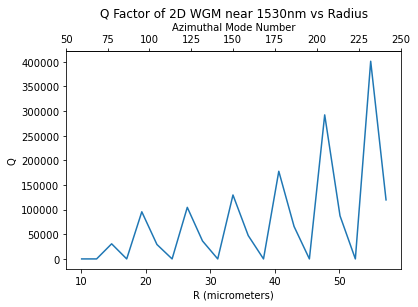

In [26]:
maxQs = []
Rs = []
Ms = []

# Iterating over azimuthal mode numbers, setting r
for m in np.arange(50, 251, 10):
    print("m = " + str(m))
    # Size of resonator and waveguide
    # r = 1 / (2 * np.pi * freq) * (m + 1 / 2 + az * ((m + 1) / 3) ** (1 / 3) - q /
    # np.sqrt(q ** 2 - 1) + 3 * az / (2 ** (2 / 3) * 10 * (m + 1 / 2) ** (1 / 3)) + q ** 3 * az / (3 * 2 ** (1 / 3) *
    # (q ** 2 - 1) ** (3 / 2) * (m + 1 / 2) ** (3 / 2)))
    r = m2rvar(m)
    print("Radius = " + str(r))
    sep = 0.1
    w = 0.1
    pad = 2

    sr = (r + pad + dpml)  # size of cell in radial direction
    cell = mp.Vector3(sr, 0, 0)

    geometry = [mp.Block(material=mp.Medium(epsilon=realPerm, D_conductivity=cond),
                         center=mp.Vector3(r / 2, 0, 0),
                         size=mp.Vector3(r, mp.inf, mp.inf)
                         )
                ]

    # Free spectral range
    fsr = 1 / (2 * np.pi * np.sqrt(realPerm) * r)

    steps = fsr / df

    # Sweeping narrow gaussians over the FSR to

    QatThisR = [0]
    frequencies = np.arange(freq - fsr, freq + fsr, df / 2)
    frequencies = np.append(frequencies, freq + fsr)
    for fcen in frequencies:
        # Waveguide Source
        # sources = [mp.Source(mp.GaussianSource(frequency=fcen, width=df),
        #                     component=mp.Ez,
        #                     center=mp.Vector3(-(r + sep + w / 2), -sy / 2 + pad),
        #                     size=mp.Vector3(w, 0))
        #           ]

        # Scattering Source in resonator
        sources = [mp.Source(mp.GaussianSource(frequency=fcen, width=df),
                             component=mp.Ez,
                             center=mp.Vector3(r - 0.1, 0))
                   ]

        sim = mp.Simulation(cell_size=cell,
                            boundary_layers=pml_layers,
                            geometry=geometry,
                            sources=sources,
                            resolution=resolution,
                            dimensions=dimensions,
                            m=int(m),
                            force_complex_fields=False,
                            Courant=0.5)

        sim.use_output_directory()

        h = mp.Harminv(mp.Ez, mp.Vector3(r - 0.1), fcen, df)

        sim.run(mp.at_beginning(mp.output_epsilon),
                mp.after_sources(h),
                until_after_sources=10000*m/50)

        QAtThisSlice = [m.Q for m in h.modes]
        QatThisR = np.append(QatThisR, QAtThisSlice)
        sim.reset_meep()
        clear_output(wait=False)
        print("m = " + str(m))
        print("Radius = " + str(r))
        print("Freq = {:e}".format(fcen))
        print("Percent of 2*FSR = {:e}/{:e}".format(fcen-freq+fsr,2*fsr))
        plt.show()


    maxQatThisR = max(QatThisR)
    maxQs = np.append(maxQs, maxQatThisR)
    print(maxQs)
    Rs = np.append(Rs, r)
    Ms = np.append(Ms, m)

    fig1, ax1 = plt.subplots()

    ax1.plot(Rs, maxQs)

    ax1.set_xlabel("R (micrometers)")
    ax1.set_ylabel("Q")
    ax1.set_title("Q Factor of 2D WGM near 1530nm vs Radius")


    def forward(x):
        return np.interp(x, Rs, Ms)


    def inverse(x):
        return np.interp(x, Ms, Rs)


    secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('Azimuthal Mode Number')
    clear_output(wait=False)
    plt.show()


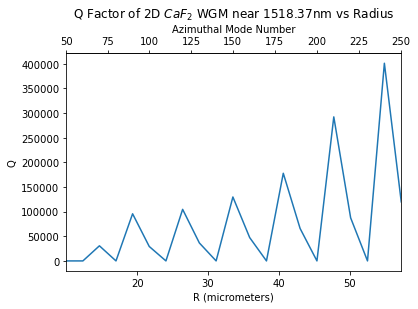

In [27]:
fig1, ax1 = plt.subplots()

ax1.plot(Rs, maxQs)

ax1.set_xlabel("R (micrometers)")
ax1.set_ylabel("Q")
ax1.set_xlim(min(Rs),max(Rs))
ax1.set_title(r"Q Factor of 2D $CaF_2$ WGM near 1518.37nm vs Radius")

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Azimuthal Mode Number')
plt.show()

In [ ]:
plt.figure()
sim.plot2D()
plt.show()